# DS422 Machine Learning Driven Data Analysis I
## Lab 3

Musabbir Hasan

In [143]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, Normalizer, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline

In [2]:
plt.rcParams["figure.figsize"] = (8,8)
font = {
    'family' : 'Serif',
    'weight' : 'bold',
    'size'   : 22
}
plt.rc('font', **font)

# Let's Make Some Data

In [3]:
# For reproducing the entire analysis
np.random.seed(27)

# Our feature, which is just 100 random values between 0 and 1
X = np.linspace(1, 3, 40).reshape(-1, 1) + np.random.rand(40, 1) * 0.5
# Our target which is modeled by cos(4x) + noise to add non-linearity.
Y = np.cos(8*X) + 1 + np.random.rand(40, 1) * 0.5

In [4]:
print(X.shape)
print(Y.shape)

(40, 1)
(40, 1)


# Let's Keep a Separate Training Data

In [5]:
# Keeping 50% data for training, and the rest for testing
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.5,
                                                    random_state=27
                                                   )

In [6]:
print('Training Features: ', x_train.shape)
print('Training Targets: ', y_train.shape)
print('Test Features: ', x_test.shape)
print('Test Targets: ', y_test.shape)

Training Features:  (20, 1)
Training Targets:  (20, 1)
Test Features:  (20, 1)
Test Targets:  (20, 1)


# Let's Check Our Training Data

Text(0.5, 1.0, 'Our Toy Training Data')

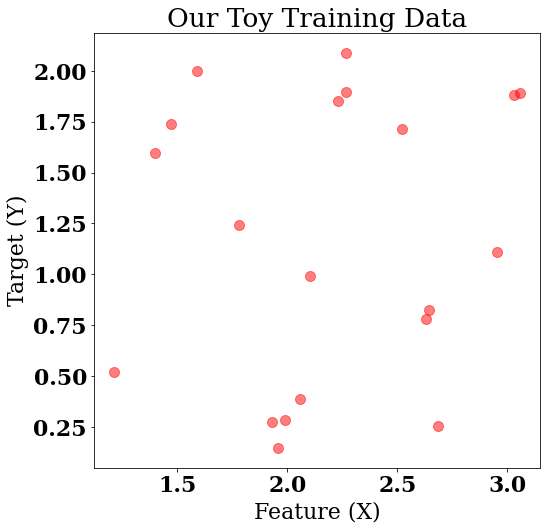

In [7]:
plt.scatter(x_train, y_train, s=100, c='r', alpha=0.5)
plt.xlabel('Feature (X)')
plt.ylabel('Target (Y)')
plt.title('Our Toy Training Data')

# Let's Check our Test Data

Text(0.5, 1.0, 'Our Toy Test Data')

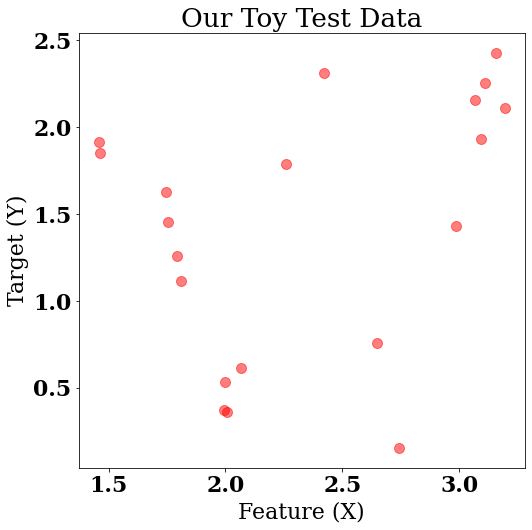

In [8]:
plt.scatter(x_test, y_test, s=100, c='r', alpha=0.5)
plt.xlabel('Feature (X)')
plt.ylabel('Target (Y)')
plt.title('Our Toy Test Data')

# Let's Implement a Linear Regression With Gradient Descent

In [9]:
pd.DataFrame(np.c_[x_train, y_train], 
             columns=['Feature', 'Target']).head()

,Feature,Target
0,1.587848,1.997525
1,1.990016,0.282568
2,3.033165,1.880607
3,2.229511,1.853369
4,1.212861,0.521656


We wan to fit a **Linear Model**. So, the equation will be $\overline{y} = f(x) = bias + weight \times feature$.

First we will add a bias term to each observation.

In [10]:
x_train_norm = np.c_[np.ones_like(x_train), x_train]
x_test_norm = np.c_[np.ones_like(x_test), x_test]

In [11]:
pd.DataFrame(np.c_[x_train_norm, y_train], 
             columns=['Bias', 'Feature', 'Target']).head()

,Bias,Feature,Target
0,1.0,1.587848,1.997525
1,1.0,1.990016,0.282568
2,1.0,3.033165,1.880607
3,1.0,2.229511,1.853369
4,1.0,1.212861,0.521656


In [12]:
x_train_norm = x_train_norm.T
x_test_norm = x_test_norm.T

In [13]:
print(x_train_norm.shape)
print(x_test_norm.shape)

(2, 20)
(2, 20)


In [14]:
pd.DataFrame(x_train_norm, 
             index=['Bias', 'Feature']).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Bias,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000
Feature,1.587848,1.990016,3.033165,2.229511,1.212861,2.643529,2.684074,1.932014,3.058738,2.51985,1.396819,2.268651,1.956221,1.470263,2.101739,2.632587,2.26609,2.95253,1.78117,2.05933


In [15]:
y_train_norm = y_train.T
y_test_norm = y_test.T

In [16]:
print(y_train_norm.shape)
print(y_test_norm.shape)

(1, 20)
(1, 20)


Now, we will set some arbitrary bias and weight.

In [17]:
bias = 0
weight = 0.125

w = np.array([
    [bias],
    [weight]
])

print(w)
print(w.shape)

[[0.   ]
 [0.125]]
(2, 1)


Now we will predict with our arbitrarily set parameters.

In [18]:
pred = w.T.dot(x_train_norm)
pred.shape

(1, 20)

In [19]:
pred

array([[0.19848097, 0.24875197, 0.37914568, 0.27868884, 0.15160759,
        0.33044116, 0.33550925, 0.24150177, 0.38234231, 0.31498125,
        0.17460232, 0.28358142, 0.24452766, 0.18378284, 0.26271738,
        0.32907336, 0.28326123, 0.36906626, 0.22264628, 0.25741629]])

Now, we will define our sum of squares error function.
$$ SSE = \sum_{i=1}^{M} (y - f(x))^2 $$
$$ SSE = \sum_{i=1}^{M} (y - bias - weight\times feature)^2 $$

In [20]:
def sse(actual, predicted):
    squared_error = (actual - predicted) ** 2
    return np.sum(squared_error)

In [21]:
error = sse(y_test, pred)
np.sqrt(error)

27.054793433265996

Now, we want to know the partial derivatives of $SSE$ with respect to both $bias$ and $weight$, which are the only $2$ parameters of our model. Then we will use the function minimization algorithm to update the parameters until error reaches minimum.

**Do you remember how the algorithms work? How the partial derivatives work?**

In [22]:
# Initialize parameters
bias = 0
weight = 0.125

w = np.array([
    [bias],
    [weight]
])

print(w)

[[0.   ]
 [0.125]]


In [23]:
epoch = np.arange(50)

errors = []
test_errors = []
params = []

lr = 0.01

M = x_train_norm.shape[1]

for e in epoch:
    
    prediction = w.T.dot(x_train_norm)
    
    mae = (y_train.T - prediction)
    error = np.sum(mae ** 2)
    
    print('Epoch: ', e)
    print('SSE: ', error)

    w[1, 0] -= lr * (-2 * mae.dot(x_train_norm[1, :]) / M)
    w[0, 0] -= lr * (-2 * np.sum(mae) / M)
    
    test_pred = w.T.dot(x_test_norm)
    test_mae = (y_test.T - test_pred)
    test_error = np.sum(test_mae ** 2)

    errors.append(error)
    test_errors.append(test_error)
    params.append(w.copy())

Epoch:  0
SSE:  25.250640318469323
Epoch:  1
SSE:  21.70300123433628
Epoch:  2
SSE:  18.958724787000467
Epoch:  3
SSE:  16.835838630044343
Epoch:  4
SSE:  15.193589674484148
Epoch:  5
SSE:  13.923107355748582
Epoch:  6
SSE:  12.940181800074708
Epoch:  7
SSE:  12.179677836294925
Epoch:  8
SSE:  11.5912143113645
Epoch:  9
SSE:  11.135822100797883
Epoch:  10
SSE:  10.783359126054304
Epoch:  11
SSE:  10.510510906308044
Epoch:  12
SSE:  10.299244012951007
Epoch:  13
SSE:  10.135609838082367
Epoch:  14
SSE:  10.008819326012624
Epoch:  15
SSE:  9.910527290904298
Epoch:  16
SSE:  9.83427884638489
Epoch:  17
SSE:  9.775081226523865
Epoch:  18
SSE:  9.729072595291994
Epoch:  19
SSE:  9.6932658752678
Epoch:  20
SSE:  9.665350602691987
Epoch:  21
SSE:  9.643539665097922
Epoch:  22
SSE:  9.626450754992703
Epoch:  23
SSE:  9.61301467592227
Epoch:  24
SSE:  9.60240441848348
Epoch:  25
SSE:  9.593980301602278
Epoch:  26
SSE:  9.587247540072585
Epoch:  27
SSE:  9.581823423635674
Epoch:  28
SSE:  9.5774

Text(0.5, 1.0, 'Ground Truth Vs. Prediction')

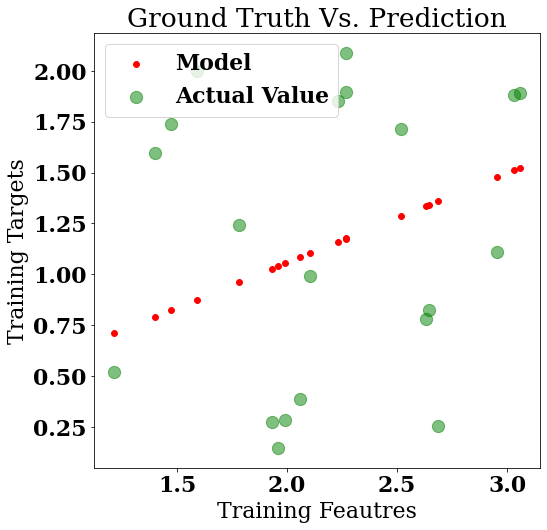

In [24]:
train_pred = w.T.dot(x_train_norm)

plt.scatter(x_train, train_pred, c='r', s=35)
plt.scatter(x_train, y_train, c='g', s=150, alpha=0.5)
plt.legend(['Model', 'Actual Value'])
plt.xlabel('Training Feautres')
plt.ylabel('Training Targets')
plt.title('Ground Truth Vs. Prediction')

Text(0.5, 1.0, 'Epoch Vs. Error')

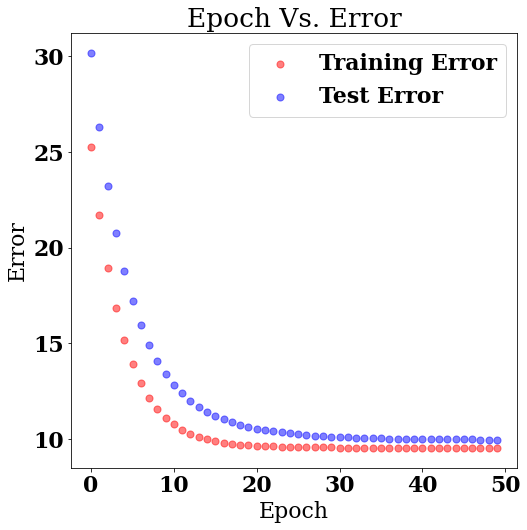

In [25]:
plt.scatter(epoch, errors, s=50, c='r', alpha=0.5)
plt.scatter(epoch, test_errors, s=50, c='b', alpha=0.5)
plt.legend(['Training Error', 'Test Error'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Epoch Vs. Error')

In [27]:
params[40]

array([[0.1693933 ],
       [0.44233414]])

Text(0.5, 1.0, 'Best Model')

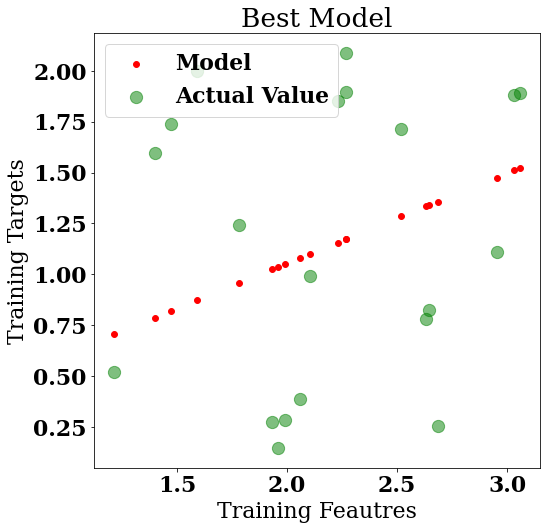

In [28]:
train_pred = params[40].T.dot(x_train_norm)

plt.scatter(x_train, train_pred, c='r', s=35)
plt.scatter(x_train, y_train, c='g', s=150, alpha=0.5)
plt.legend(['Model', 'Actual Value'])
plt.xlabel('Training Feautres')
plt.ylabel('Training Targets')
plt.title('Best Model')

**We need to talk about these 3 measure of errors. Where, when, and why use them.**

**Train Error of Best Model**

In [29]:
train_pred = params[40].T.dot(x_train_norm).T

print('Mean Absolute Error (MAE): ', mean_absolute_error(train_pred, y_train))
print('Mean Squared Error (MSE): ', mean_squared_error(train_pred, y_train))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_absolute_error(train_pred, y_train)))

Mean Absolute Error (MAE):  0.6289697308525009
Mean Squared Error (MSE):  0.47768640729351597
Root Mean Squared Error (RMSE):  0.7930761192045193


**Test Error of Best Model**

In [30]:
test_pred = params[40].T.dot(x_test_norm).T

print('Mean Absolute Error (MAE): ', mean_absolute_error(test_pred, y_test))
print('Mean Squared Error (MSE): ', mean_squared_error(test_pred, y_test))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_absolute_error(test_pred, y_test)))

Mean Absolute Error (MAE):  0.6408416861885582
Mean Squared Error (MSE):  0.5006766118178366
Root Mean Squared Error (RMSE):  0.800525881023567


In [32]:
min(y_train), max(y_train)

(array([0.1457692]), array([2.0891643]))

**Evaluation**

Variance is low because of a low complexity model (a linear model on polynomial curve). But bias is high. Can we do better?

**This is good time to review irreducible error, bias, and variance, isn't it?**

# Let's Do a Polynomial Regression

We will convert our single feature X into a `m` degree polynomial using the `PolynomialFeatures` class. We will try values $1-5$ for `m` to see which one is better.

$$m = 0, W_0X^0 =  w_0$$
$$m = 1, W_0X^0 + W_2X^1 = W_0 + W_1X$$
$$m = 2, W_0 + W_1X + W_2X^2$$

In [33]:
# placeholers for losses for all values of m
degree = []
train_loss = []
test_loss = []
coef_mag = []

In [186]:
deg = 6

pf = PolynomialFeatures(degree=deg, include_bias=True)
pf.fit(x_train)

degree.append(deg)

In [187]:
x_train_poly = pf.transform(x_train)
x_test_poly = pf.transform(x_test)

In [188]:
print('Before: ', ' '.join([str(i) for i in x_train[0]]))
print()
print('After: ', ' '.join([str(i) for i in x_train_poly[0]]))

Before:  1.5878477537860216

After:  1.0 1.5878477537860216 2.521260489203314 4.0033778044909285 6.356754454417736 10.09355828181649 16.02703384549061


Now we will use these 10 features to fit our training data. We will first use the **Leas Square** Method.

In [189]:
lr = LinearRegression()
lr.fit(x_train_poly, y_train)

LinearRegression()

## Training Error

In [190]:
train_pred = lr.predict(x_train_poly)

print('Mean Absolute Error (MAE): ', mean_absolute_error(train_pred, y_train))
print('Mean Squared Error (MSE): ', mean_squared_error(train_pred, y_train))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_absolute_error(train_pred, y_train)))

train_loss.append(np.sqrt(mean_absolute_error(train_pred, y_train)))

Mean Absolute Error (MAE):  0.3646179749987625
Mean Squared Error (MSE):  0.16355254022336446
Root Mean Squared Error (RMSE):  0.6038360497674534


Text(0.5, 1.0, 'Ground Truth Vs. Prediction')

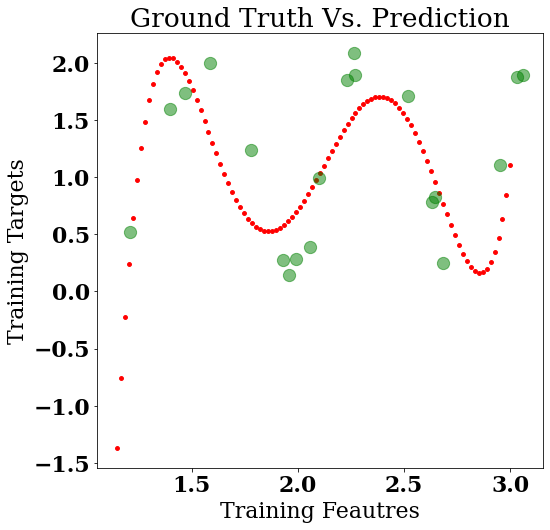

In [191]:
ex = np.linspace(1.15, 3, 100).reshape(-1, 1)
ex_poly = pf.transform(ex)
ex_pred = lr.predict(ex_poly)

plt.scatter(ex, ex_pred, c='r', s=15)
plt.scatter(x_train, y_train, c='g', s=150, alpha=0.5)
plt.xlabel('Training Feautres')
plt.ylabel('Training Targets')
plt.title('Ground Truth Vs. Prediction')

## Coefficients

In [192]:
mag = 0
for i, c in enumerate(lr.coef_[0]):
    mag += np.abs(c)
    print('Feature ', str(i), ': ', str(c))

coef_mag.append(mag)

Feature  0 :  0.0
Feature  1 :  1664.6521384057878
Feature  2 :  -1678.085303730464
Feature  3 :  822.7662799627004
Feature  4 :  -195.8501454610704
Feature  5 :  17.833403176515844
Feature  6 :  0.09175437155113286


## Test Predict

In [134]:
lr_pred = lr.predict(x_test_poly)

In [135]:
print('Mean Absolute Error (MAE): ', mean_absolute_error(lr_pred, y_test))
print('Mean Squared Error (MSE): ', mean_squared_error(lr_pred, y_test))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_absolute_error(lr_pred, y_test)))

test_loss.append(np.sqrt(mean_absolute_error(lr_pred, y_test)))

Mean Absolute Error (MAE):  0.5096259106211417
Mean Squared Error (MSE):  0.3607290160452965
Root Mean Squared Error (RMSE):  0.7138808798540144


Text(0.5, 1.0, 'Ground Truth Vs. Prediction')

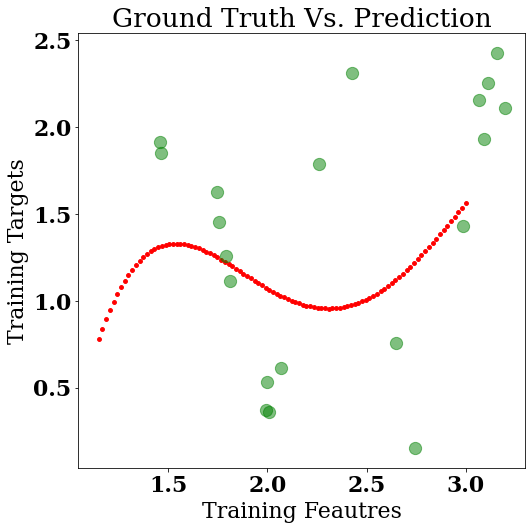

In [136]:
plt.scatter(ex, ex_pred, c='r', s=15)
plt.scatter(x_test, y_test, c='g', s=150, alpha=0.5)
plt.xlabel('Training Feautres')
plt.ylabel('Training Targets')
plt.title('Ground Truth Vs. Prediction')

# Evaluation

Text(0.5, 1.0, 'Degree Vs. Error')

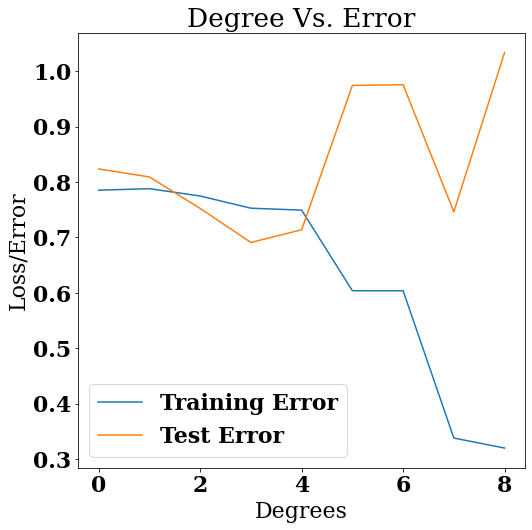

In [126]:
plt.plot(degree, train_loss)
plt.plot(degree, test_loss)
plt.legend(['Training Error', 'Test Error'])
plt.ylabel('Loss/Error')
plt.xlabel('Degrees')
plt.title('Degree Vs. Error')

Text(0.5, 0, 'Degrees')

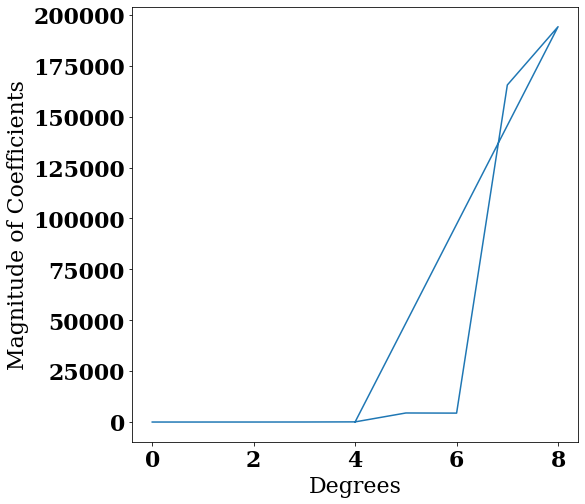

In [137]:
plt.plot(degree, coef_mag)
plt.ylabel('Magnitude of Coefficients')
plt.xlabel('Degrees')

Text(0.5, 1.0, 'Degree Vs. Coefficient Magnitudes')

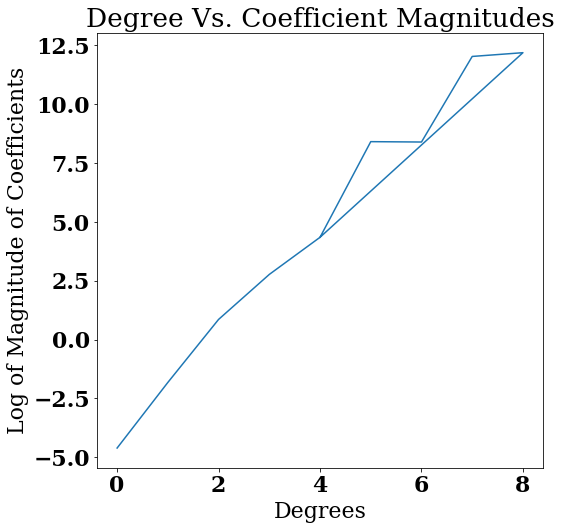

In [138]:
# Why I added 0.01 to coef_mag?
plt.plot(degree, np.log(np.array(coef_mag)+0.01))
plt.ylabel('Log of Magnitude of Coefficients')
plt.xlabel('Degrees')
plt.title('Degree Vs. Coefficient Magnitudes')

# Regularization

Punishing large weights!

In [171]:
pf = PolynomialFeatures(degree=6, include_bias=True)
pf.fit(x_train)

PolynomialFeatures(degree=6)

In [172]:
x_train_poly = pf.transform(x_train)
x_test_poly = pf.transform(x_test)

In [173]:
print(x_train_poly.shape)
print(x_test_poly.shape)

(20, 7)
(20, 7)


In [174]:
pd.DataFrame(x_train_poly).head()

,0,1,2,3,4,5,6
0,1.0,1.587848,2.521260,4.003378,6.356754,10.093558,16.027034
1,1.0,1.990016,3.960163,7.880786,15.682888,31.209193,62.106785
2,1.0,3.033165,9.200092,27.905402,84.641701,256.732280,778.711472
3,1.0,2.229511,4.970718,11.082270,24.708039,55.086839,122.816699
4,1.0,1.212861,1.471031,1.784156,2.163932,2.624549,3.183212


In [180]:
ridge = Lasso(alpha=1,
             max_iter=1000)

In [181]:
ridge.fit(x_train_poly, y_train.reshape(-1))

Lasso(alpha=1)

In [182]:
train_error = ridge.predict(x_train_poly)

print('Mean Absolute Error (MAE): ', mean_absolute_error(train_error, y_train))
print('Mean Squared Error (MSE): ', mean_squared_error(train_error, y_train))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_absolute_error(train_error, y_train)))

Mean Absolute Error (MAE):  0.6092502164690282
Mean Squared Error (MSE):  0.4380053692764996
Root Mean Squared Error (RMSE):  0.7805448202819798


In [183]:
sgd_pred = ridge.predict(x_test_poly)

In [184]:
print('Mean Absolute Error (MAE): ', mean_absolute_error(sgd_pred, y_test))
print('Mean Squared Error (MSE): ', mean_squared_error(sgd_pred, y_test))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_absolute_error(sgd_pred, y_test)))

Mean Absolute Error (MAE):  0.5883034533850527
Mean Squared Error (MSE):  0.4331026633454432
Root Mean Squared Error (RMSE):  0.7670094219662837


Text(0.5, 1.0, 'Ground Truth Vs. Prediction')

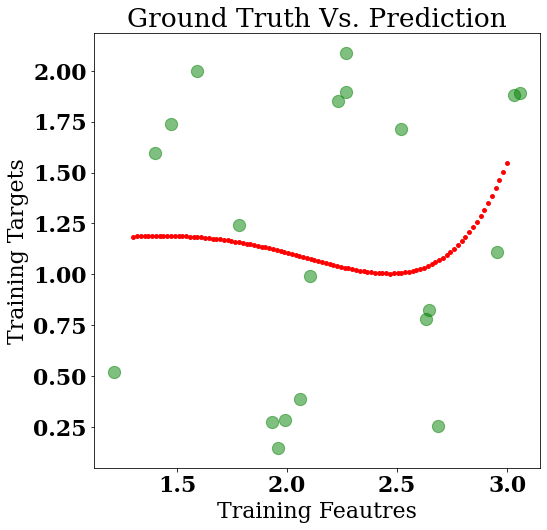

In [170]:
ex = np.linspace(1.3, 3, 100).reshape(-1, 1)
ext = pf.transform(ex)
train_pred = ridge.predict(ext)

plt.scatter(ex, train_pred, c='r', s=15)
plt.scatter(x_train, y_train, c='g', s=150, alpha=0.5)
plt.xlabel('Training Feautres')
plt.ylabel('Training Targets')
plt.title('Ground Truth Vs. Prediction')

In [185]:
ridge.coef_

array([ 0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.00056053])